In [13]:
import tensorflow as tf


def positional_encoding(length, dim, n=10000):
    """Position encoding using sine and cosine functions to represent the order information

    Args:
        length: sequence length
        d: vector dimension, even only
        n: Constant for the sinusoidal functions

    Output shape
      - 2D tensor with shape: ``(length, dim)``.

    References
      - [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)
    """
    assert length % 2 == 0, "Output dimension needs to be an even integer"
    half_dim = dim // 2
    # shape [length, 1] column vector
    pos = tf.reshape(tf.range(length, dtype=tf.float32), [-1, 1])
    # shape [1, half_dim] row vector
    i = tf.reshape(tf.range(half_dim, dtype=tf.float32), [1, -1])
    # n**(-2*i/dim)
    denom = tf.math.pow(n, -i / half_dim)
    # shape [length, half_dim]
    args = pos * denom
    # shape [length, half_dim, 1] generate even dimensions
    sin = tf.expand_dims(tf.math.sin(args), axis=-1)
    # shape [length, half_dim, 1] generate odd dimensions
    cos = tf.expand_dims(tf.math.cos(args), axis=-1)
    # shape [length, half_dim, 2] -> [length, dim], concat and interleave
    pe = tf.reshape(tf.concat([sin, cos], axis=-1), [length, dim])
    return pe, sin, cos


In [14]:
import matplotlib.pyplot as plt

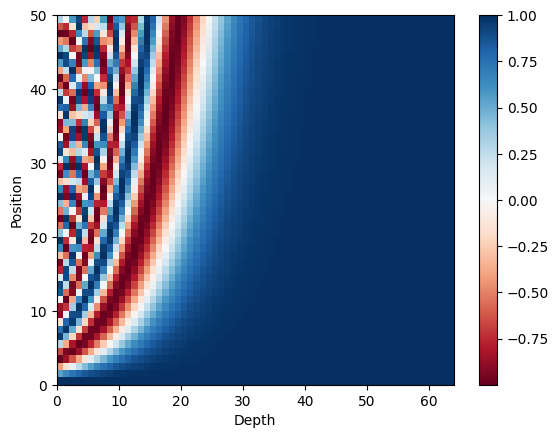

In [28]:
pos_matrix, sin, cos = positional_encoding(50, 128)
plt.pcolormesh(tf.squeeze(cos), cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

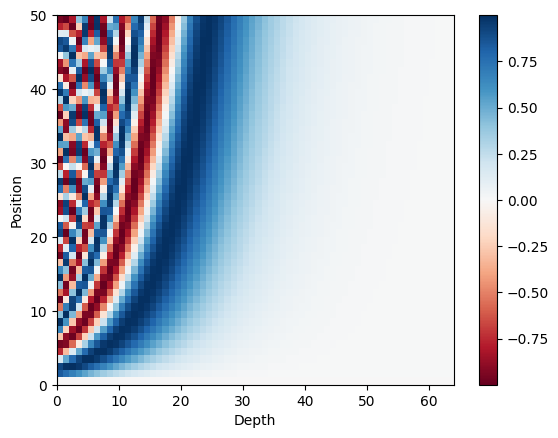

In [19]:
plt.pcolormesh(tf.squeeze(sin), cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

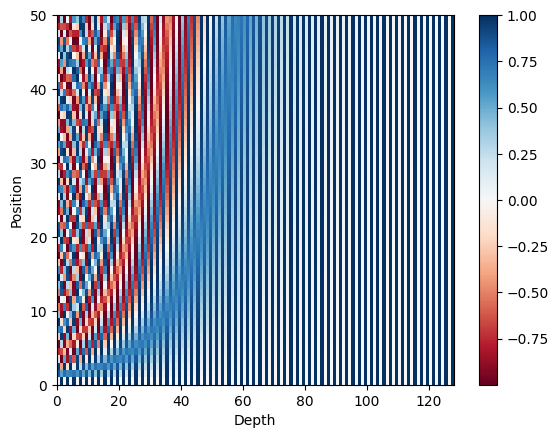

In [20]:
plt.pcolormesh(tf.squeeze(pos_matrix), cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

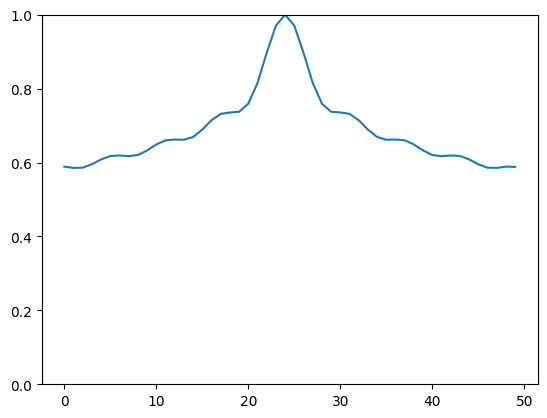

In [36]:
pos_matrix, sin, cos = positional_encoding(50, 128)
pos_matrix = tf.math.l2_normalize(pos_matrix, axis=1)
p = pos_matrix[24]  # all vectors compare to vector at position 24
dots = tf.reduce_sum(pos_matrix * p, axis=1, keepdims=True)
plt.plot(dots)
plt.ylim([0, 1])
plt.show()

In [39]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """Position embedding is composed of a positional encoding layer and a normal embedding layer

    Input shape
      - two 2D tensor with shape: ``(batch_size, sequence_length)``.

    Output shape
      - 3D tensor with shape: ``(batch_size, sequence_length, embedding_size)``.


        References
        - [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)
    """

    def __init__(self, vocab_size, length=100, dim=512, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        assert length % 2 == 0, "Output dimension needs to be an even integer"
        self.length = length
        self.dim = dim
        self.token_emb = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=dim, mask_zero=True
        )
        # positional embedding layer: a matrix of hard-coded sine values
        self.pos_enc = self.positional_encoding()

    def positional_encoding(self, n=10000):
        """Position encoding using sine and cosine functions to represent the order information

        Args:
            n: Constant for the sinusoidal functions

        Output shape
        - 2D tensor with shape: ``(length, dim)``.
        """
        half_dim = self.dim // 2
        # shape [length, 1] column vector
        pos = tf.reshape(tf.range(self.length, dtype=tf.float32), [-1, 1])
        # shape [1, half_dim] row vector
        i = tf.reshape(tf.range(half_dim, dtype=tf.float32), [1, -1])
        # n**(-2*i/dim)
        denom = tf.math.pow(n, -i / half_dim)
        # shape [length, half_dim]
        args = pos * denom
        # shape [length, half_dim, 1] generate even dimensions
        sin = tf.expand_dims(tf.math.sin(args), axis=-1)
        # shape [length, half_dim, 1] generate odd dimensions
        cos = tf.expand_dims(tf.math.cos(args), axis=-1)
        # shape [length, half_dim, 2] -> [length, dim], concat and interleave
        pe = tf.reshape(tf.concat([sin, cos], axis=-1), [self.length, self.dim])
        return pe

    def call(self, inputs, **kwargs):
        embedded_tokens = self.token_emb(inputs)
        return embedded_tokens + self.pos_enc

    # Pass mask from token_emb, https://www.tensorflow.org/guide/keras/understanding_masking_and_padding#supporting_masking_in_your_custom_layers
    def compute_mask(self, inputs, mask=None):
        return self.token_emb.compute_mask(inputs, mask=mask)

    def get_config(self):
        # to make save and load a model using custom layer possible
        config = super().get_config()
        config.update(
            {
                "length": self.length,
                "vocab_size": self.vocab_size,
                "dim": self.dim,
            }
        )
        return config


In [54]:
pe = PositionalEmbedding(10, 10)

In [69]:
emb = pe(
    tf.random.uniform(shape=[10, 10],
    minval=1,
    maxval=10,
    dtype=tf.int32)
)

In [78]:
emb

<tf.Tensor: shape=(10, 10, 512), dtype=float32, numpy=
array([[[ 0.03588433,  1.032602  ,  0.02694911, ...,  0.9936179 ,
         -0.00402592,  1.0147771 ],
        [ 0.8047156 ,  0.55081356,  0.787245  , ...,  1.023689  ,
         -0.04648498,  0.9963771 ],
        [ 0.92224276, -0.46178618,  0.9018142 , ...,  0.9771035 ,
          0.00399884,  1.0445437 ],
        ...,
        [ 0.6709986 ,  0.7458006 ,  0.47713935, ...,  1.0437793 ,
          0.03165063,  0.9858292 ],
        [ 0.9743317 , -0.10220985,  0.95382386, ...,  1.0112578 ,
          0.04600058,  0.9823861 ],
        [ 0.44220904, -0.9389873 ,  0.70952946, ...,  0.96534616,
         -0.00840485,  0.9639776 ]],

       [[-0.0452957 ,  1.0101635 ,  0.00272833, ...,  1.0369557 ,
         -0.01713864,  1.0360311 ],
        [ 0.8715615 ,  0.5124452 ,  0.85501605, ...,  0.96534663,
         -0.00923416,  0.963978  ],
        [ 0.8832218 , -0.38999936,  0.9001574 , ...,  1.0356207 ,
         -0.0393174 ,  1.001401  ],
        ...,

In [85]:
class MultiHeadSelfAttentionLayer(tf.keras.layers.Layer):
    """Multi-head self attention layer that models the token interactions

    Input shape
      - query: 3D tensor with shape ``(batch_size, query_length, embedding_size)``.
      - key: 3D tensor with shape ``(batch_size, key_length, embedding_size)``.
      - value: 3D tensor with shape ``(batch_size, key_length, embedding_size)``.

    Output shape
      - 3D tensor with shape: ``(batch_size, query_length, embedding_size)``.

    References
        - [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)
    """

    def __init__(
        self,
        head_num=8,
        key_dim=64,
        val_dim=None,
        dropout=0.1,
        **kwargs,
    ):
        super(MultiHeadSelfAttentionLayer, self).__init__(**kwargs)
        self.key_dim = key_dim
        self.val_dim = val_dim
        self.head_num = head_num
        self.key_output_dim = key_dim * head_num
        self.val_output_dim = val_dim * head_num if val_dim else self.key_output_dim
        self.dropout = tf.keras.layers.Dropout(dropout)

    def build(self, input_shape: tf.Tensor):
        embedding_size = input_shape[-1]
        self.W_Query = self.add_weight(
            name="query",
            shape=[embedding_size, self.key_output_dim],
        )
        self.W_Key = self.add_weight(
            name="key",
            shape=[embedding_size, self.key_output_dim],
        )
        self.W_Value = self.add_weight(
            name="value",
            shape=[embedding_size, self.val_output_dim],
        )
        self.W_Output = self.add_weight(
            name="output",
            shape=[self.val_output_dim, embedding_size],
        )

    def call(
        self,
        query,
        key,
        value,
        use_causal_mask=False,
        training=None,
    ):
        # shape [head_num, batch_size, query_length, key_length]
        mask = self._compute_attention_mask(
            query, key, value, use_causal_mask=use_causal_mask
        )
        # shape [batch_size, query_length, key_dim * head_num]
        querys = tf.matmul(query, self.W_Query)
        # shape [batch_size, key_length, key_dim * head_num]
        keys = tf.matmul(key, self.W_Key)
        # shape [batch_size, key_length, val_dim * head_num]
        values = tf.matmul(value, self.W_Value)

        # reshape and move the head_num to axis 0
        # shape [head_num, batch_size, query_length, key_dim]
        querys = tf.stack(tf.split(querys, self.head_num, axis=2), axis=0)
        # shape [head_num, batch_size, key_length, key_dim]
        keys = tf.stack(tf.split(keys, self.head_num, axis=2), axis=0)
        # shape [head_num, batch_size, key_length, val_dim]
        values = tf.stack(tf.split(values, self.head_num, axis=2), axis=0)

        # shape [head_num, batch_size, query_length, key_length]
        weights = tf.matmul(querys, keys, transpose_b=True)
        # scale
        weights /= self.key_dim**0.5
        # mask
        tf.print(mask[0], summarize=-1)
        if mask is not None:
            adder = (1.0 - tf.cast(mask, weights.dtype)) * -1e9
            weights += adder
        scores = tf.nn.softmax(weights, axis=-1)
        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        scores = self.dropout(scores, training=training)

        # weighted_sum
        # shape [head_num, batch_size, query_length, val_dim]
        outputs = tf.matmul(scores, values)
        # restore shape
        # shape [[1, batch_size, query_length, val_dim]], head_num lists of tensor
        outputs = tf.split(outputs, self.head_num, axis=0)
        # shape [1, batch_size, query_length, val_dim * head_num]
        outputs = tf.concat(outputs, axis=-1)
        # shape [batch_size, query_length, val_dim * head_num]
        outputs = tf.squeeze(outputs, axis=0)

        # shape [batch_size, query_length, embedding_size]
        outputs = tf.matmul(outputs, self.W_Output)
        return outputs

    def _compute_attention_mask(self, query, key, value, use_causal_mask=False):
        """Computes the attention mask, using the Keras masks of the inputs.

            * The `query`'s mask is reshaped from [batch_size, query_length] to [batch_size, query_length, 1].
            * The `value`'s mask is reshaped from [batch_size, key_length] to [batch_size, 1, key_length].
            * The `key`'s mask is reshaped from [batch_size, key_length] to [batch_size, 1, key_length]. The `key`'s
              mask is ignored if `key` is `None` or if `key is value`.
            * If `use_causal_mask=True`, then the causal mask is computed. Its shape
              is [1, query_length, key_length].

            All defined masks are merged using a logical AND operation (`&`).

        Input shape
          - query: 3D tensor with shape ``(batch_size, query_length, embedding_size)``.
          - key: 3D tensor with shape ``(batch_size, key_length, embedding_size)``.
          - value: 3D tensor with shape ``(batch_size, key_length, embedding_size)``.

        Output shape
          - 3D tensor with shape: ``(batch_size, query_length, embedding_size)``.
        """
        query_mask = getattr(query, "_keras_mask", None)
        value_mask = getattr(value, "_keras_mask", None)
        key_mask = getattr(key, "_keras_mask", None)
        auto_mask = None
        if query_mask is not None:
            query_mask = tf.cast(query_mask, tf.bool)  # defensive casting
            # B = batch size, T = max query length
            auto_mask = query_mask[:, :, tf.newaxis]  # shape is [B, T, 1]
        if value_mask is not None:
            value_mask = tf.cast(value_mask, tf.bool)  # defensive casting
            # B = batch size, S == max value length
            mask = value_mask[:, tf.newaxis, :]  # shape is [B, 1, S]
            auto_mask = mask if auto_mask is None else auto_mask & mask
        if key_mask is not None:
            key_mask = tf.cast(key_mask, tf.bool)  # defensive casting
            # B == batch size, S == max key length == max value length
            mask = key_mask[:, tf.newaxis, :]  # shape is [B, 1, S]
            auto_mask = mask if auto_mask is None else auto_mask & mask
        if use_causal_mask:
            # the shape of the causal mask is [1, T, S]
            mask = self._compute_causal_mask(query, value)
            auto_mask = mask if auto_mask is None else auto_mask & mask
        return auto_mask

    def _compute_causal_mask(self, query, value=None):
        """Computes a causal mask (e.g., for masked self-attention layers).

        For example, if query and value both contain sequences of length 4,
        this function returns a boolean `Tensor` equal to:

        ```
        [[[True,  False, False, False],
          [True,  True,  False, False],
          [True,  True,  True,  False],
          [True,  True,  True,  True]]]
        ```

        Args:
            query: query `Tensor` of shape `(batch_size, query_length, ...)`.
            value: value `Tensor` of shape `(batch_size, key_length, ...)` (optional, defaults to
                query).

        Returns:
            mask: a boolean `Tensor` of shape [1, T, S] containing a lower
                triangular matrix of shape [T, S].
        """
        q_seq_length = tf.shape(query)[1]
        v_seq_length = q_seq_length if value is None else tf.shape(value)[1]
        return tf.linalg.band_part(  # creates a lower triangular matrix
            tf.ones((1, q_seq_length, v_seq_length), tf.bool), -1, 0
        )


In [86]:
mh = MultiHeadSelfAttentionLayer()

In [87]:
mh(emb, emb, emb, use_causal_mask=True)

[[1 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 1 1 0 0 0]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1]]


<tf.Tensor: shape=(10, 10, 512), dtype=float32, numpy=
array([[[-1.2190394 , -0.54823476, -0.34819153, ...,  0.19564891,
          0.31552103, -0.6108452 ],
        [-1.036228  , -0.54550654, -0.37314975, ...,  0.16548815,
          0.2974077 , -0.42880735],
        [-0.8592664 , -0.4479282 , -0.39542365, ...,  0.1752555 ,
          0.29040474, -0.2135129 ],
        ...,
        [-0.65782344, -0.18045859, -0.54069215, ...,  0.09229523,
          0.26832968, -0.1697404 ],
        [-0.67190826, -0.16856006, -0.5271582 , ...,  0.08548886,
          0.2709361 , -0.19025534],
        [-0.68527937, -0.13746913, -0.517965  , ...,  0.09743598,
          0.28605762, -0.19499493]],

       [[-1.2186723 , -0.5438431 , -0.36177066, ...,  0.16877876,
          0.23604873, -0.66079813],
        [-1.0444018 , -0.5284543 , -0.38130644, ...,  0.1643454 ,
          0.2586022 , -0.4197836 ],
        [-0.873826  , -0.44070256, -0.40503395, ...,  0.17768747,
          0.27392566, -0.20869386],
        ...,